In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth 
auth.authenticate_user()

# Generate creds for the Drive FUSE library.

from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.

!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Connected to the Drive')


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input/facial-expression/fer2013/"))

# Any results you write to the current directory are saved as output.


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145655 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


**Reading data**

In [0]:
dataset_path = 'drive/Colab Notebooks/icml_face_data.csv'
tempList = []
for chunk in pd.read_csv(dataset_path, chunksize=20000):
    tempList.append(chunk)
data = pd.concat(tempList, axis=0)
del tempList
pixels = data[' pixels'].tolist()


**Changing data to fit the model**

In [4]:
image_size = (48, 48)
faces = []
for pixel in pixels:
    face = [int(pixel) for pixel in pixel.split(' ')]
    face = np.asarray(face).reshape(48, 48)
    face = cv2.resize(face.astype('uint8'), image_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
emotions = pd.get_dummies(data['emotion']).as_matrix()

faces = faces.astype('float32')
faces = faces / 255.0
faces = faces - 0.5
faces = faces * 2.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


**Splitting data for training and testing**

In [0]:
xtrain, xtest, ytrain, ytest = train_test_split(faces, emotions, test_size=0.2, shuffle=True)

**Creating the network model**

In [6]:
input_shape = (48, 48, 1)
num_classes = 7
regularization_value=0.01
 
regularization = l2(regularization_value)
 
img = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)

model = Model(img, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', 'mse'])
model.summary()















Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 46, 8)    0           batch_normalization_1[0][0]      
______________________________________________________________________________

**Fitting data to the model**

In [7]:
model_data = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False,
                        rotation_range=10, width_shift_range=0.1,
                        height_shift_range=0.1, zoom_range=.1,
                        horizontal_flip=True)
batch_size = 32
history_object = model.fit_generator(model_data.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=20, verbose=1,
                        validation_data=(xtest,ytest))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
898/897 [==============================] - 46s 52ms/step - loss: 1.7460 - acc: 0.3382 - mean_squared_error: 0.1105 - val_loss: 1.6150 - val_acc: 0.4188 - val_mean_squared_error: 0.1031
Epoch 2/20
898/897 [==============================] - 39s 44ms/step - loss: 1.4964 - acc: 0.4380 - mean_squared_error: 0.0979 - val_loss: 1.4943 - val_acc: 0.4471 - val_mean_squared_error: 0.0977
Epoch 3/20
898/897 [==============================] - 40s 44ms/step - loss: 1.3907 - acc: 0.4747 - mean_squared_error: 0.0925 - val_loss: 1.3193 - val_acc: 0.5040 - val_mean_squared_error: 0.0887
Epoch 4/20
898/897 [==============================] - 39s 43ms/step - loss: 1.3261 - acc: 0.5012 - mean_squared_error: 0.0890 - val_loss: 1.2788 - val_acc: 0.5291 - val_mean_squared_error: 0.0860
Epoch 5/20
898/897 [==============================] - 40s 44ms/step - loss: 1.2832 - acc: 0.5166 - mean_squared_error: 0

Traning accuracy per epoch

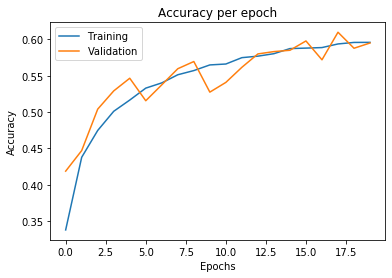

In [15]:
import matplotlib.pyplot as plt

epoch_list = np.arange(20)
plt.plot(epoch_list, history_object.history['acc'], label="Training")
plt.plot(epoch_list, history_object.history['val_acc'], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.legend(loc='upper left')
plt.show()

Validation accuracy per epoch

<function matplotlib.pyplot.show>

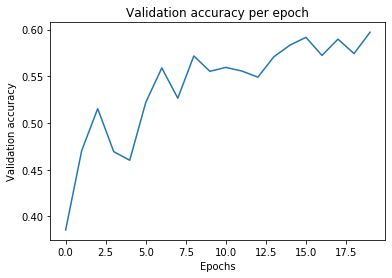

In [26]:

plt.plot(epoch_list, history_object.history['val_acc'])
plt.plot(epoch_list, history_object.history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy per epoch")
plt.show

Training loss per epoch

<function matplotlib.pyplot.show>

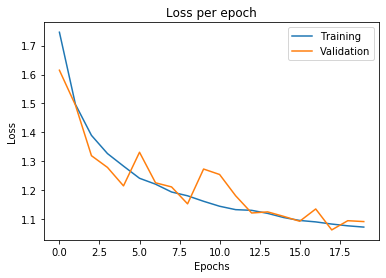

In [17]:

plt.plot(epoch_list, history_object.history['loss'], label="Training")
plt.plot(epoch_list, history_object.history['val_loss'], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.legend(loc='upper right')
plt.show

Validation loss per epoch

<function matplotlib.pyplot.show>

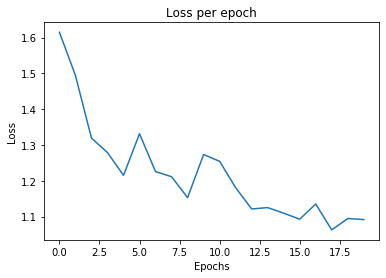

In [16]:

plt.plot(epoch_list, history_object.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show

Plot of the model

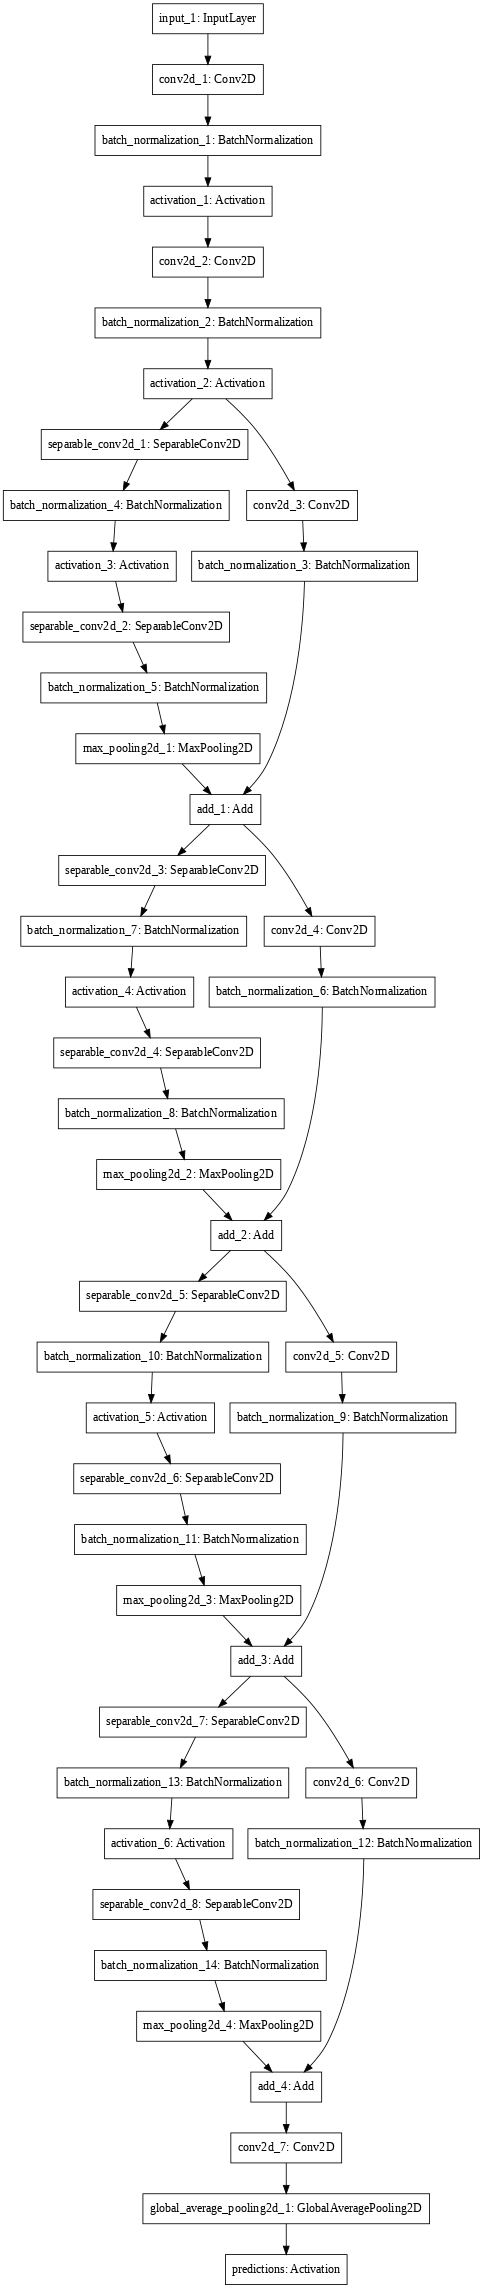

In [13]:
plot_model(model, to_file='vgg2.png', dpi = 60)